# 9.1 CNN
Implement a deep convolutional neural network from scratch using a popular deep learning framework (e.g., TensorFlow or PyTorch). Train and evaluate the network on a standard image classification dataset, such as CIFAR-10 or MNIST.

Note: As mentioned in class, it is okay to copy code from online resources for this section. Credits to https://blog.paperspace.com/writing-cnns-from-scratch-in-pytorch/amp/ and https://towardsdatascience.com/simple-guide-to-hyperparameter-tuning-in-neural-networks-3fe03dad8594 for the set up of this.

In [7]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [8]:
batch_size = 64

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [9]:
all_transforms = transforms.Compose([transforms.Resize((32,32)),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                                                          std=[0.2023, 0.1994, 0.2010])
                                     ])
# Create Training dataset
train_dataset = torchvision.datasets.CIFAR10(root = './data',
                                             train = True,
                                             transform = all_transforms,
                                             download = True)

# Create Testing dataset
test_dataset = torchvision.datasets.CIFAR10(root = './data',
                                            train = False,
                                            transform = all_transforms,
                                            download=True)

# Instantiate loader objects to facilitate processing
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)


test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


50000 10000


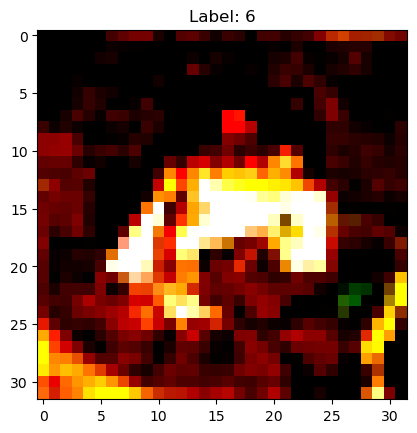

In [10]:
len_train_dataset = len(train_dataset)
len_test_dataset = len(test_dataset)
print(len_train_dataset, len_test_dataset)

image, label = train_dataset[0] 
np_image = image.numpy()
np_image = np.transpose(np_image, (1, 2, 0)) 
plt.imshow(np_image)
plt.title(f'Label: {label}')
plt.show()

#### a) First, experiment blindly with various hyperparameters and architectures and observe the model's performance.

We have experimented with multiple learning rates and kernel sizes. To save time, only the learning rates are included here.
To calculate the compression ratio of this network we multiply
$$
\left(\frac{64 \times 32 \times 32 \times 3}{64 \times 30 \times 30 \times 32}\right) \times \left(\frac{64 \times 30 \times 30 \times 32}{64 \times 28 \times 28 \times 32}\right) \times \left(\frac{64 \times 14 \times 14 \times 32}{64 \times 12 \times 12 \times 64}\right) \times \left(\frac{64 \times 12 \times 12 \times 64}{64 \times 10 \times 10 \times 64}\right)
$$

$$
= \frac{32}{900} \times \frac{900}{784} \times \frac{98}{144} \times \frac{36}{25} = 0.12 * 4 * 4 = 1.92 
$$

Each image is size 32x32x3 since there are 3 channels, and our ouput is 1600 in the linear layer. So 
$$
\frac{32 \times 32 \times 3}{1600} = 1.92
$$


To compare this with the MEC, we multiply it by 8 bits, because in CIFAR-10, each pixel can maximally be represented with 8 bits.
$$
\frac{32 \times 32 \times 3 \times 8}{1.92} = 12800
$$



To find the MEC of the network, we calculate
$$
(1600+1)*128 + min(128, 10) = 204938
$$

In [20]:
class ConvNeuralNet(nn.Module):
    #  Determine what layers and their order in CNN object 
    def __init__(self, num_classes):
        super(ConvNeuralNet, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.conv_layer3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv_layer4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.fc1 = nn.Linear(1600, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)
    
    # Progresses data across layers
    def forward(self, x):
        out = self.conv_layer1(x)
        #print(f"Shape of first conv : {out.shape}")
        out = self.conv_layer2(out)
        print(f"Shape of second conv : {out.shape}")
        out = self.max_pool1(out)
        
        out = self.conv_layer3(out)
        #print(f"Shape of third conv : {out.shape}")
        out = self.conv_layer4(out)
        #print(f"Shape of fourth conv : {out.shape}")
        out = self.max_pool2(out)
                
        out = out.reshape(out.size(0), -1)
        
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

In [13]:
num_classes = 10
num_epochs = 20

learning_rates = [0.1, 0.01, 0.001, 0.0001]

total_step = len(train_loader)

In [ ]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for lr in learning_rates:
    model = ConvNeuralNet(num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=0.005, momentum=0.9)
    
    lr_train_losses = []
    lr_train_accuracies = []
    lr_val_losses = []
    lr_val_accuracies = []
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        total_train_loss = 0
        correct_train = 0
        total_train = 0

        for i, (images, labels) in enumerate(train_loader):  
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        lr_train_losses.append(avg_train_loss)
        lr_train_accuracies.append(train_accuracy)
        
        # Validation
        model.eval()
        total_val_loss = 0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()

        avg_val_loss = total_val_loss / len(test_loader)
        val_accuracy = 100 * correct_val / total_val
        lr_val_losses.append(avg_val_loss)
        lr_val_accuracies.append(val_accuracy)

        # Optional: Print statistics
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Test Loss: {avg_val_loss:.4f}, Test Accuracy: {val_accuracy:.2f}%')

    train_losses.append(lr_train_losses)
    train_accuracies.append(lr_train_accuracies)
    val_losses.append(lr_val_losses)
    val_accuracies.append(lr_val_accuracies)


Epoch [1/20], Training Loss: nan, Training Accuracy: 10.32%, Test Loss: nan, Test Accuracy: 10.00%
Epoch [2/20], Training Loss: nan, Training Accuracy: 10.00%, Test Loss: nan, Test Accuracy: 10.00%
Epoch [3/20], Training Loss: nan, Training Accuracy: 10.00%, Test Loss: nan, Test Accuracy: 10.00%
Epoch [4/20], Training Loss: nan, Training Accuracy: 10.00%, Test Loss: nan, Test Accuracy: 10.00%
Epoch [5/20], Training Loss: nan, Training Accuracy: 10.00%, Test Loss: nan, Test Accuracy: 10.00%
Epoch [6/20], Training Loss: nan, Training Accuracy: 10.00%, Test Loss: nan, Test Accuracy: 10.00%
Epoch [7/20], Training Loss: nan, Training Accuracy: 10.00%, Test Loss: nan, Test Accuracy: 10.00%
Epoch [8/20], Training Loss: nan, Training Accuracy: 10.00%, Test Loss: nan, Test Accuracy: 10.00%
Epoch [9/20], Training Loss: nan, Training Accuracy: 10.00%, Test Loss: nan, Test Accuracy: 10.00%
Epoch [10/20], Training Loss: nan, Training Accuracy: 10.00%, Test Loss: nan, Test Accuracy: 10.00%
Epoch [11

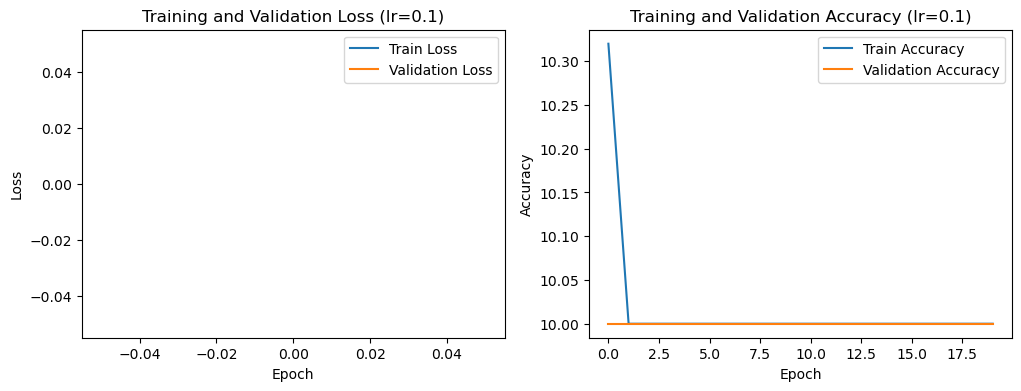

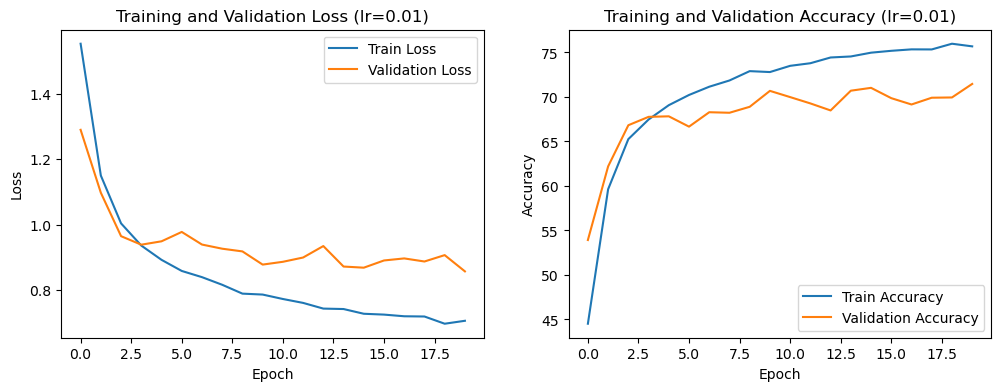

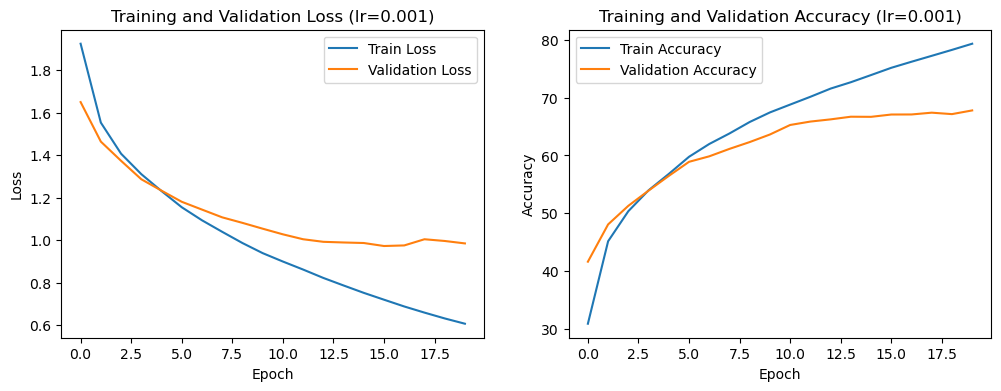

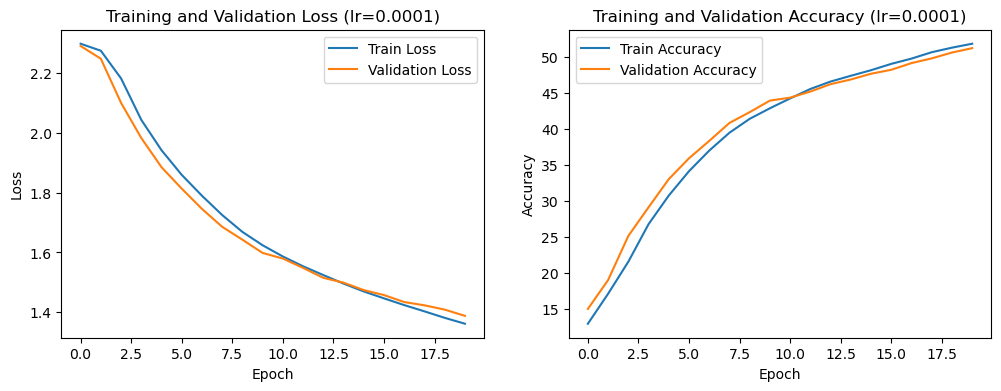

In [12]:
for i, lr in enumerate(learning_rates):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses[i], label='Train Loss')
    plt.plot(val_losses[i], label='Validation Loss')
    plt.title(f'Training and Validation Loss (lr={lr})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies[i], label='Train Accuracy')
    plt.plot(val_accuracies[i], label='Validation Accuracy')
    plt.title(f'Training and Validation Accuracy (lr={lr})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

#### b) Second, apply the measurements proposed in this book to reduce the hyperparameter search space and observe the model's performance.


In this part of the problem we add a layer to the network. This changes the compression ratio, so it now becomes

$$
\left(\frac{64 \times 32 \times 32 \times 3}{64 \times 30 \times 30 \times 32}\right) \times \left(\frac{64 \times 30 \times 30 \times 32}{64 \times 28 \times 28 \times 32}\right) \times \left(\frac{64 \times 14 \times 14 \times 32}{64 \times 12 \times 12 \times 64}\right) \times \left(\frac{64 \times 12 \times 12 \times 64}{64 \times 10 \times 10 \times 64}\right) \times \left(\frac{64 \times 5 \times 5 \times 64}{64 \times 3 \times 3 \times 64}\right)
$$

$$
= \frac{32}{900} \times \frac{900}{784} \times \frac{98}{144} \times \frac{36}{25} \times \frac{25}{9} = 0.333 * 4 * 4 = 5.333
$$

Each image is size 32x32x3 since there are 3 channels, and our ouput is now 576 into the linear layer. So 
$$
\frac{32 \times 32 \times 3}{576} = 5.333
$$

which is the same

To compare this with the MEC, we multiply it by 8 bits, because in CIFAR-10, each pixel can maximally be represented with 8 bits.
$$
\frac{32 \times 32 \times 3 \times 8}{5.33} = 4610.88
$$

To find the MEC of the network, we calculate
$$
(576+1)*128 + min(128, 10) = 73866
$$

In [11]:
class ConvNeuralNet(nn.Module):
    #  Determine what layers and their order in CNN object 
    def __init__(self, num_classes):
        super(ConvNeuralNet, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.conv_layer2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3)
        self.max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.conv_layer3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.conv_layer4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        
        self.conv_layer5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3)
        
        self.fc1 = nn.Linear(576, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, num_classes)
    
    # Progresses data across layers
    def forward(self, x):
        out = self.conv_layer1(x)
        #print(f"Shape of first conv : {out.shape}")
        out = self.conv_layer2(out)
        # print(f"Shape of second conv : {out.shape}")
        out = self.max_pool1(out)
        
        out = self.conv_layer3(out)
        #print(f"Shape of third conv : {out.shape}")
        out = self.conv_layer4(out)
        #print(f"Shape of fourth conv : {out.shape}")
        out = self.max_pool2(out)
                
        out = out.reshape(out.size(0), -1)
        
        out = self.fc1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        return out

In [14]:
lr = 0.01

model = ConvNeuralNet(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=0.005, momentum=0.9)

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training
    model.train()
    total_train_loss = 0
    correct_train = 0
    total_train = 0

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)
    
    # Validation
    model.eval()
    total_val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = total_val_loss / len(test_loader)
    val_accuracy = 100 * correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, Test Loss: {avg_val_loss:.4f}, Test Accuracy: {val_accuracy:.2f}%')

Epoch [1/20], Training Loss: 1.5524, Training Accuracy: 44.72%, Test Loss: 1.2309, Test Accuracy: 56.74%
Epoch [2/20], Training Loss: 1.1456, Training Accuracy: 59.80%, Test Loss: 1.0904, Test Accuracy: 62.54%
Epoch [3/20], Training Loss: 0.9985, Training Accuracy: 65.34%, Test Loss: 0.9900, Test Accuracy: 66.01%
Epoch [4/20], Training Loss: 0.9286, Training Accuracy: 67.91%, Test Loss: 1.0053, Test Accuracy: 65.17%
Epoch [5/20], Training Loss: 0.8848, Training Accuracy: 69.40%, Test Loss: 0.9814, Test Accuracy: 66.30%
Epoch [6/20], Training Loss: 0.8529, Training Accuracy: 70.82%, Test Loss: 0.9949, Test Accuracy: 65.73%
Epoch [7/20], Training Loss: 0.8264, Training Accuracy: 71.39%, Test Loss: 0.9135, Test Accuracy: 68.42%
Epoch [8/20], Training Loss: 0.8065, Training Accuracy: 72.25%, Test Loss: 0.9865, Test Accuracy: 67.23%
Epoch [9/20], Training Loss: 0.7902, Training Accuracy: 72.86%, Test Loss: 0.8706, Test Accuracy: 69.78%
Epoch [10/20], Training Loss: 0.7776, Training Accuracy

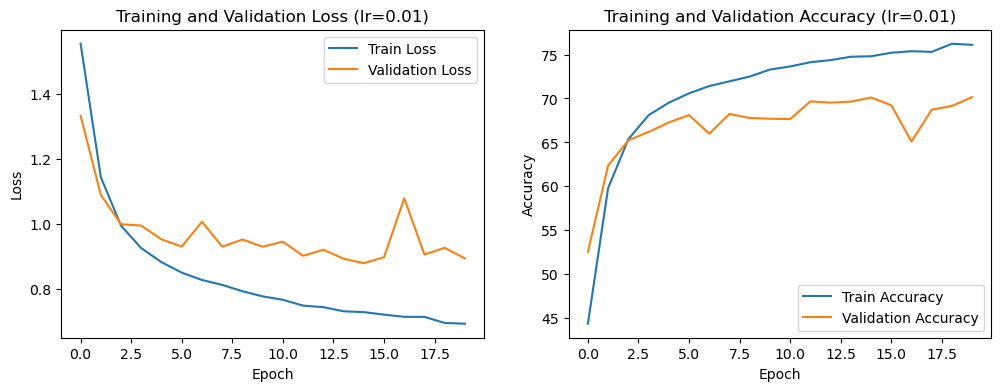

In [26]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title(f'Training and Validation Loss (lr={lr})')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title(f'Training and Validation Accuracy (lr={lr})')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()